## Import 

In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds



In [3]:
import matplotlib.pyplot as plt
import pandas as pd


## Load Data

In [66]:
#comment data_dir first time you use this cell
data_dir = '/home/chinzi/code/Solid32/LeafScan-back/raw_data'

(train_ds, val_ds, test_ds), metadata = tfds.load(
    'plant_village',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
    data_dir=data_dir,
    shuffle_files=True
)

,image,label
0,,4 (Blueberry___healthy)
1,,24 (Soybean___healthy)
2,,23 (Raspberry___healthy)
3,,31 (Tomato___Late_blight)
4,,32 (Tomato___Leaf_Mold)

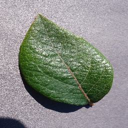
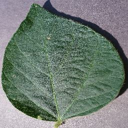
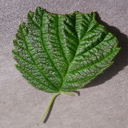
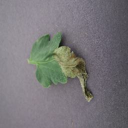
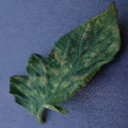

In [67]:
tfds.as_dataframe(val_ds.take(5), metadata)

In [62]:
builder.list

AttributeError: 'Builder' object has no attribute 'list'

In [49]:
temp = [    "Apple scab",    "Apple black rot",    "Apple cedar apple rust",    "Apple healthy",    "Blueberry healthy",    "Cherry powdery mildew",    "Cherry healthy",    "Corn gray leaf spot",    "Corn common rust",    "Corn northern leaf blight",    "Corn healthy",    "Grape black rot",    "Grape black measles",    "Grape leaf blight",    "Grape healthy",    "Orange haunglongbing",    "Peach bacterial spot",    "Peach healthy",    "Pepper bacterial spot",    "Pepper healthy",    "Potato early blight",    "Potato healthy",    "Potato late blight",    "Raspberry healthy",    "Soybean healthy",    "Squash powdery mildew",    "Strawberry healthy",    "Strawberry leaf scorch",    "Tomato bacterial spot",    "Tomato early blight",    "Tomato healthy",    "Tomato late blight",    "Tomato leaf mold",    "Tomato septoria leaf spot",    "Tomato spider mites two-spotted spider mite",    "Tomato target spot",    "Tomato mosaic virus",    "Tomato yellow leaf curl virus"]


In [50]:
index_dict={key:value for key, value in zip(temp, range(39))}

In [51]:
index_dict

{'Apple scab': 0,
 'Apple black rot': 1,
 'Apple cedar apple rust': 2,
 'Apple healthy': 3,
 'Blueberry healthy': 4,
 'Cherry powdery mildew': 5,
 'Cherry healthy': 6,
 'Corn gray leaf spot': 7,
 'Corn common rust': 8,
 'Corn northern leaf blight': 9,
 'Corn healthy': 10,
 'Grape black rot': 11,
 'Grape black measles': 12,
 'Grape leaf blight': 13,
 'Grape healthy': 14,
 'Orange haunglongbing': 15,
 'Peach bacterial spot': 16,
 'Peach healthy': 17,
 'Pepper bacterial spot': 18,
 'Pepper healthy': 19,
 'Potato early blight': 20,
 'Potato healthy': 21,
 'Potato late blight': 22,
 'Raspberry healthy': 23,
 'Soybean healthy': 24,
 'Squash powdery mildew': 25,
 'Strawberry healthy': 26,
 'Strawberry leaf scorch': 27,
 'Tomato bacterial spot': 28,
 'Tomato early blight': 29,
 'Tomato healthy': 30,
 'Tomato late blight': 31,
 'Tomato leaf mold': 32,
 'Tomato septoria leaf spot': 33,
 'Tomato spider mites two-spotted spider mite': 34,
 'Tomato target spot': 35,
 'Tomato mosaic virus': 36,
 'To

In [19]:
train_ds = train_ds.batch(32)

val_ds = val_ds.batch(32)

test_ds = test_ds.batch(32)

In [12]:
metadata.features['image'].shape 

(None, None, 3)

In [13]:
input_shape = metadata.features['image'].shape


## Model

In [23]:
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(256,256,3)),
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.CenterCrop(height=224, width=224), 
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.Conv2D(64, 4, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(246, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(38, activation='softmax')
])

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 center_crop_1 (CenterCrop)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 conv2d_2 (Conv2D)           (None, 221, 221, 64)      3136      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 110, 110, 64)     0         
 2D)                                                  

In [32]:
initial_learning_rate = 0.0015
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,  
    decay_rate=0.9  
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [33]:
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [35]:
from tensorflow.keras.callbacks import EarlyStopping


es = EarlyStopping(patience=3, restore_best_weights=True)


In [ ]:
model.fit(train_ds,
          callbacks=es,
          validation_data=val_ds,
          epochs=2)

Epoch 1/20
1358/1358 [==============================] - 107s 77ms/step - loss: 0.5933 - accuracy: 0.8103 - val_loss: 0.5617 - val_accuracy: 0.8266
Epoch 2/20
1358/1358 [==============================] - 105s 77ms/step - loss: 0.5549 - accuracy: 0.8243 - val_loss: 0.5349 - val_accuracy: 0.8291
Epoch 3/20
1358/1358 [==============================] - 107s 79ms/step - loss: 0.5176 - accuracy: 0.8337 - val_loss: 0.4458 - val_accuracy: 0.8597
Epoch 4/20
1358/1358 [==============================] - 104s 77ms/step - loss: 0.4860 - accuracy: 0.8453 - val_loss: 0.5038 - val_accuracy: 0.8415
Epoch 5/20
1358/1358 [==============================] - 104s 77ms/step - loss: 0.4535 - accuracy: 0.8539 - val_loss: 0.4459 - val_accuracy: 0.8571
Epoch 6/20
1358/1358 [==============================] - 106s 78ms/step - loss: 0.4240 - accuracy: 0.8618 - val_loss: 0.4313 - val_accuracy: 0.8617
Epoch 7/20
1358/1358 [==============================] - 105s 77ms/step - loss: 0.4037 - accuracy: 0.8685 - val_loss: 0

In [31]:
model.evaluate(test_ds)

170/170 [==============================] - 4s 24ms/step - loss: 0.6191 - accuracy: 0.8109


[0.6190786361694336, 0.810865581035614]

## Transfer Learning 

In [ ]:
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Dense

# Charger le modèle VGG16 pré-entraîné
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Ajouter une couche Dense supplémentaire
x = base_model.output
x = Dense(256, activation='relu')(x)
predictions = Dense(38, activation='softmax')(x)

# Créer le nouveau modèle en spécifiant les couches d'entrée et de sortie
model = Model(inputs=base_model.input, outputs=predictions)

# Visualiser l'architecture du nouveau modèle
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
model.fit(train_ds,
          validation_data=val_ds,
          epochs=5)

Epoch 1/5


InvalidArgumentError: ignored